In [1]:
with open('./KG_mapping/umls/umls.csv', 'r') as f:
    lines_1 = f.readlines()

triple_set = set()
tuple_set = set()

for line in lines_1:
    items = line.split('\t')
    e1 = items[1]
    r = items[0]
    e2 = items[2]
    triple_set.add((e1, r, e2))

In [2]:
len(triple_set)

1212586

In [ ]:
from pyhealth.datasets import MIMIC3Dataset
from GraphCare.task_fn import drug_recommendation_fn

mimic3_ds = MIMIC3Dataset(
    root="../../../data/physionet.org/files/mimiciii/1.4/", 
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],      
    code_mapping={
        "NDC": ("ATC", {"target_kwargs": {"level": 3}}),
        # "ICD9CM": "CCSCM",
        # "ICD9PROC": "CCSPROC"
        },
)

sample_dataset = mimic3_ds.set_task(drug_recommendation_fn)     

In [18]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/drugrec_dataset_umls.pkl', 'wb') as f:
    pickle.dump(sample_dataset, f)

In [45]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/drugrec_dataset_umls.pkl', 'rb') as f:
    sample_dataset = pickle.load(f)

In [46]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [41]:
from pyhealth.tokenizer import Tokenizer
import numpy as np
from tqdm import tqdm
import torch

def multihot(label, num_labels):
    multihot = np.zeros(num_labels)
    for l in label:
        multihot[l] = 1
    return multihot

def prepare_label(drugs):
    label_tokenizer = Tokenizer(
        sample_dataset.get_all_tokens(key='drugs')
    )

    labels_index = label_tokenizer.convert_tokens_to_indices(drugs)
    # print(labels_index)
    # convert to multihot
    num_labels = label_tokenizer.get_vocabulary_size()
    # print(num_labels)
    labels = multihot(labels_index, num_labels)
    return labels


for patient in tqdm(sample_dataset):
    # patient['drugs_all'] = flatten(patient['drugs'])
    # print(patient['drugs_all'])
    patient['drugs_ind'] = torch.tensor(prepare_label(patient['drugs']))

100%|██████████| 44399/44399 [1:09:22<00:00, 10.67it/s]


In [5]:
with open('./KG_mapping/RxNorm_to_ATC3_UMLS.csv', 'r') as f:
    lines = f.readlines()
    lines = lines[1:]

rxnorm_to_umls = {}
for line in lines:
    rxnorm, umls = line.split(',')
    umls = umls[:-1]
    rxnorm_to_umls[rxnorm.replace('.', '')] = umls

with open('./KG_mapping/ICD9CM_to_UMLS.csv', 'r') as f:
    lines = f.readlines()
    lines = lines[1:]

icd9_to_umls = {}
for line in lines:
    icd9cm, umls = line.split(',')
    umls = umls[:-1]
    icd9_to_umls[icd9cm.replace('.', '')] = umls


In [42]:
import json
import numpy as np

with open('./graphs/condition/ICD9CM_base/ent2id_new.json', 'r') as f:
    ent2id = json.load(f)

with open('./graphs/condition/ICD9CM_base/rel2id_new.json', 'r') as f:
    rel2id = json.load(f)

with open('./graphs/condition/ICD9CM_base/miss_ent2id.json', 'r') as f:
    m_ent2id = json.load(f)

m_ent2id_update = {icd9_to_umls[key]: value+len(ent2id) for key, value in m_ent2id.items()}
ent2id.update(m_ent2id_update)

ent_emb = np.load('./graphs/condition/ICD9CM_base/kg_ent_emb_new.npy')
m_ent_emb = np.load('./graphs/condition/ICD9CM_base/kg_ent_emb_miss.npy')

In [8]:
ent_emb == m_ent_emb[:len(ent_emb)]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
len(m_ent_emb), len(ent2id)

(67248, 67248)

In [47]:
from sklearn.cluster import AgglomerativeClustering, KMeans

# Set up the hierarchical clustering algorithm
cluster_alg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.20, linkage='average', affinity='cosine')
# cluster_alg = KMeans(n_clusters=1000)
# Fit the algorithm to your data
cluster_labels = cluster_alg.fit_predict(m_ent_emb)

/home/pj20/miniconda3/envs/kgc/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [48]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/cluster_labels_th020_new.pkl', 'wb') as f:
    pickle.dump(cluster_labels, f)

In [49]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/cluster_labels_th020_new.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

In [50]:
from collections import defaultdict
import json

def nested_dict():
    return defaultdict(list)

map_cluster = defaultdict(nested_dict)

for unique_l in np.unique(cluster_labels):
    for cur in range(len(cluster_labels)):
        if cluster_labels[cur] == unique_l:
            map_cluster[str(unique_l)]['nodes'].append(cur)

# map_cluster = defaultdict(nested_dict)
# i = 0
# for key in map_cluster_.keys():
#     if len(map_cluster_[key]['nodes']) > 100:
#         for node in map_cluster_[key]['nodes']:
#             map_cluster[str(i)]['nodes'] = [node]
#             i+=1
#     else:
#         map_cluster[str(i)]['nodes'] = map_cluster_[key]['nodes']
#         i+=1

for unique_l in map_cluster.keys():
    nodes = map_cluster[unique_l]['nodes']
    nodes = np.array(nodes)
    embedding_mean = np.mean(m_ent_emb[nodes], axis=0)
    map_cluster[unique_l]['embedding'].append(embedding_mean.tolist())

map_cluster_inv = {}
for cluster_label, item in map_cluster.items():
    for node in item['nodes']:
        map_cluster_inv[str(node)] = cluster_label

In [51]:
len(map_cluster), len(m_ent_emb)

(764, 67248)

In [52]:
with open('../../../data/pj20/exp_data/icd9cm_icd9proc/clusters_umls_th020.json', 'w', encoding='utf-8') as f:
    json.dump(map_cluster, f, indent=6)

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/clusters_inv_umls_th020.json', 'w', encoding='utf-8') as f:
    json.dump(map_cluster_inv, f, indent=6)

In [53]:
ent_emb = m_ent_emb

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

np.random.seed(528)

# Select 500 random rows from ent_emb
sample_indices = np.random.choice(ent_emb.shape[0], size=3000, replace=False)
sample_ent_emb = ent_emb[sample_indices, :]
sample_cluster_labels = cluster_labels[sample_indices]

# Compute the t-SNE projection of the embeddings
tsne = TSNE(n_components=2, perplexity=30,random_state=528)
embeddings_2d = tsne.fit_transform(sample_ent_emb)

cluster_emb = []
# Plot the cluster centers, colored by cluster label
for cluster_label in range(len(map_cluster)):
    cluster_emb.append(np.array(map_cluster[str(cluster_label)]['embedding'][0]))

cluster_embedding_2d = tsne.fit_transform(np.array(cluster_emb))


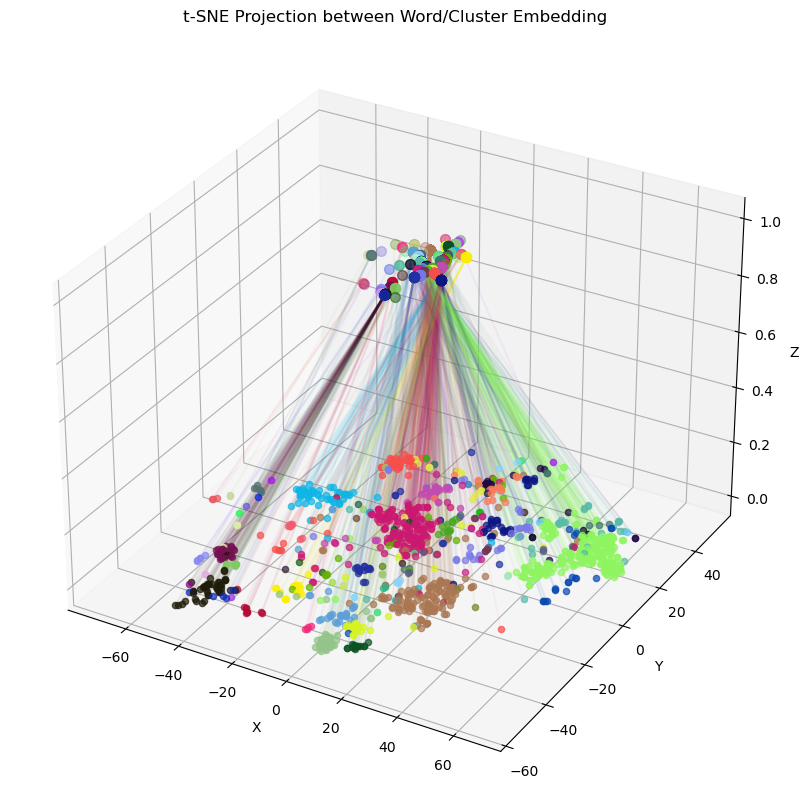

In [55]:
import matplotlib.colors as mcolors
from matplotlib.cm import Paired
import random
import seaborn as sns

# Function to generate a random HEX color
def generate_hex_color():
    hex_digits = '0123456789ABCDEF'
    color = '#' + ''.join(random.choice(hex_digits) for _ in range(6))
    return color

comfortable_colors = sns.color_palette('bright', 30).as_hex()

# Define the projection plane coordinates
plane1_coords = np.array([[1, 0, 0], [0, 1, 0], [1, 1, 0], [0, 0, 0]])
plane2_coords = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 1], [0, 0, 1]])

# Create a custom colormap using the Paired colormap
colors = {}
for i, label in enumerate(sample_cluster_labels):
    colors[label] = generate_hex_color()

# Create a single 3D subplot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the embeddings on the first plane
for i, label in enumerate(sample_cluster_labels):
    if label < 80:
        ax.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], 0, c=colors[label], alpha=0.7)
        ax.scatter(cluster_embedding_2d[label, 0], cluster_embedding_2d[label, 1], 1, s=50, c=colors[label], alpha=0.3)
        ax.plot([embeddings_2d[i, 0], cluster_embedding_2d[label, 0]],
                [embeddings_2d[i, 1], cluster_embedding_2d[label, 1]],
                [0, 1], c=colors[label], alpha=0.05)

# Plot the two planes
ax.plot(plane1_coords[:, 0], plane1_coords[:, 1], plane1_coords[:, 2], c='gray', alpha=0.1)
ax.plot(plane2_coords[:, 0], plane2_coords[:, 1], plane2_coords[:, 2], c='gray', alpha=0.1)

# Plot the projection line between the two planes
line_xs = [1, 0]
line_ys = [0, 1]
line_zs = [0, 1]

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('t-SNE Projection between Word/Cluster Embedding')

plt.savefig('clus_umls_cp_th020.pdf', format='pdf')

plt.show()

In [56]:
len(map_cluster_inv), len(ent2id), len(map_cluster)

(67248, 67213, 764)

In [57]:
icd9_to_umls['V3000']

'C0260602'

In [58]:
import networkx as nx
from tqdm import tqdm

G = nx.Graph()

# for key in ent2id.keys():
#     G.add_nodes_from([
#         (int(ent2id[key]), {'y': int(ent2id[key])})
#     ])

for cluster_label, item in map_cluster.items():
    G.add_nodes_from([
        (int(cluster_label), {'y': int(cluster_label), 'x': item['embedding'][0]})
    ])

triples_all = []
for patient in tqdm(sample_dataset):
    triples = []
    triple_set = set()

    conditions = flatten(patient['conditions'])
    for condition in conditions:
        try:
            cond_file = f'./graphs/condition/ICD9CM_base/{condition}.txt'
            with open(cond_file, 'r') as f:
                lines = f.readlines()

            for line in lines:
                items = line.split('\t')
                if len(items) == 3:
                    h, r, t = items
                    t = t[:-1]
                    h = ent2id[h]
                    t = ent2id[t]
                    triple = (h, r, t)
                    if triple not in triple_set:
                        # triples.append((int(h), int(t)))
                        triples.append((int(map_cluster_inv[str(h)]), int(map_cluster_inv[str(t)])))
                        triple_set.add(triple)
        except:
            try:
                # triples.append((int(ent2id[condition]), int(ent2id[condition])))
                triples.append((int(map_cluster_inv[str(ent2id[icd9_to_umls[condition]])]), int(map_cluster_inv[str(ent2id[icd9_to_umls[condition]])])))
            except:
                # print(f"Condition {condition} not in KG")
                continue
                # ent2id[icd9_to_umls[condition]] = len(ent2id)
                # triples.append((int(ent2id[icd9_to_umls[condition]]), int(ent2id[icd9_to_umls[condition]])))
                # G.add_nodes_from([
                #     (int(ent2id[icd9_to_umls[condition]]), {'y': int(ent2id[icd9_to_umls[condition]])})
                # ])
    
    procedures = flatten(patient['procedures'])
    for procedure in procedures:
        try:
            proc_file = f'./graphs/condition/ICD9CM_base/{procedure}.txt'
            with open(proc_file, 'r') as f:
                lines = f.readlines()
            for line in lines:
                items = line.split('\t')
                if len(items) == 3:
                    h, r, t = items
                    t = t[:-1]
                    h = ent2id[h]
                    t = ent2id[t]
                    triple = (h, r, t)
                    if triple not in triple_set:
                        # triples.append((int(h), int(t)))
                        triples.append((int(map_cluster_inv[str(h)]), int(map_cluster_inv[str(t)])))
                        triple_set.add(triple)
        except:
            try:
                # triples.append((int(ent2id[procedure]), int(ent2id[procedure])))
                triples.append((int(map_cluster_inv[str(ent2id[icd9_to_umls[procedure]])]), int(map_cluster_inv[str(ent2id[icd9_to_umls[procedure]])])))
            except:
                # print(f"Procedure {procedure} not in KG")
                continue
                # ent2id[icd9_to_umls[procedure]] = len(ent2id)
                # triples.append((int(ent2id[icd9_to_umls[procedure]]), int(ent2id[icd9_to_umls[procedure]])))
                # G.add_nodes_from([
                #     (int(ent2id[icd9_to_umls[procedure]]), {'y': int(ent2id[icd9_to_umls[procedure]])})
                # ])
    
    G.add_edges_from(
        triples
    )



100%|██████████| 44399/44399 [01:46<00:00, 416.68it/s]


In [59]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/graph_umls_th020_drugrec.pkl', 'wb') as f:
    pickle.dump(G, f)

In [60]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/graph_umls_th020_drugrec.pkl', 'rb') as f:
    G = pickle.load(f)

In [61]:
from torch_geometric.utils import to_networkx, from_networkx
G_tg = from_networkx(G) 

In [62]:
len(G_tg.y)

764

In [63]:
G_tg.x

tensor([[-0.0286,  0.0108,  0.0031,  ..., -0.0088, -0.0003, -0.0287],
        [-0.0025, -0.0024,  0.0071,  ..., -0.0119, -0.0029, -0.0167],
        [ 0.0055, -0.0041,  0.0073,  ..., -0.0184, -0.0085, -0.0046],
        ...,
        [-0.0192,  0.0061, -0.0077,  ...,  0.0254,  0.0017, -0.0264],
        [-0.0447, -0.0169, -0.0033,  ..., -0.0139, -0.0008, -0.0041],
        [-0.0005, -0.0124,  0.0066,  ..., -0.0219,  0.0023, -0.0090]])

In [64]:
map_cluster_inv['0']

'3'

In [65]:
import torch
from tqdm import tqdm

c_v, p_v, d_v = [], [], []
for patient in sample_dataset:
    c_v.append(len(patient['conditions']))
    p_v.append(len(patient['procedures']))

print(max(c_v), max(p_v))
max_visits = max(c_v)

def pad_and_convert(visits, max_visits, max_nodes):
    padded_visits = []
    for visit in visits:
        visit_multi_hot = torch.zeros(max_nodes)
        for idx, med_code in enumerate(visit):
            visit_multi_hot[med_code] = 1
        padded_visits.append(visit_multi_hot)
    while len(padded_visits) < max_visits:
        padded_visits.append(torch.zeros(max_nodes))
    return torch.stack(padded_visits, dim=0)
        

miss_node = set()
for patient in tqdm(sample_dataset): 
    node_set_list_c = []
    node_set_list_p = []
    node_set_list_d = []
    node_set_all = set()

    for visit_i in range(len(patient['conditions'])):
        triple_set = set()
        node_set = set()  
        conditions = patient['conditions'][visit_i]
        procedures = patient['procedures'][visit_i]
        
        for condition in conditions:
            try:
                cond_file = f'./graphs/condition/ICD9CM_base/{condition}.txt'
                with open(cond_file, 'r') as f:
                    lines = f.readlines()
                for line in lines:
                    items = line.split('\t')
                    if len(items) == 3:
                        h, r, t = items
                        t = t[:-1]
                        h = ent2id[h]
                        # r = int(rel2id[r]) + len(ent_emb)
                        t = ent2id[t]
                        triple = (h, r, t)
                        if triple not in triple_set:
                            triple_set.add(triple)
                            node_set.add(int(map_cluster_inv[str(h)]))
                            # node_set.add(r)
                            node_set.add(int(map_cluster_inv[str(t)]))
            except:
                # node_set.add(ent2id[condition])
                # try:
                    node_set.add(int(map_cluster_inv[str(ent2id[icd9_to_umls[condition]])]))
                # except:
                #     miss_node.add(condition)
                #     continue

        
        node_set_list_c.append([*node_set])
        node_set_all.update(node_set)
        triple_set = set()
        node_set = set()  

        for procedure in procedures:
            try:
                proc_file = f'./graphs/condition/ICD9CM_base/{procedure}.txt'
                with open(proc_file, 'r') as f:
                    lines = f.readlines()
                for line in lines:
                    items = line.split('\t')
                    if len(items) == 3:
                        h, r, t = items
                        t = t[:-1]
                        h = ent2id[h]
                        # r = int(rel2id[r]) + len(ent_emb)
                        t = ent2id[t]
                        triple = (h, r, t)
                        if triple not in triple_set:
                            triple_set.add(triple)
                            node_set.add(int(map_cluster_inv[str(h)]))
                            # node_set.add(r)
                            node_set.add(int(map_cluster_inv[str(t)]))
            except:
                # node_set.add(ent2id[condition])
                # try:
                    node_set.add(int(map_cluster_inv[str(ent2id[icd9_to_umls[procedure]])]))
                # except:
                #     miss_node.add(procedure)
                #     continue
        
        node_set_list_p.append([*node_set])
        node_set_all.update(node_set)

    
    pad_c_v = pad_and_convert(node_set_list_c, max_visits=max_visits, max_nodes=len(G_tg.y))
    pad_p_v = pad_and_convert(node_set_list_p, max_visits=max_visits, max_nodes=len(G_tg.y))
    patient['visit_node_set_condition'] = pad_c_v
    patient['visit_node_set_procedure'] = pad_p_v
    patient['node_set'] = [*node_set_all]

    

29 29


100%|██████████| 44399/44399 [01:53<00:00, 392.54it/s]


In [66]:
import pickle

with open('../../../data/pj20/exp_data/icd9cm_icd9proc/drugrec_dataset_umls_th020.pkl', 'wb') as f:
    pickle.dump(sample_dataset, f)

In [46]:
# with open('./graphs/condition/ICD9CM_base/miss_node.pkl', 'wb') as f:
#     pickle.dump(miss_node, f)

In [49]:
# idx = 0
# miss_ent2id = {}
# for mn in miss_node:
#     miss_ent2id[mn] = idx
#     idx += 1

# with open('./graphs/condition/ICD9CM_base/miss_ent2id.json', 'w') as f:
#     json.dump(miss_ent2id, f, indent=6)

In [69]:
with open('../../../data/pj20/exp_data/icd9cm_icd9proc/clusters_umls_th015.json', 'r', encoding='utf-8') as f:
    map_cluster = json.load(f)

In [70]:
len(map_cluster)

5573